# TODO

- ~~noisy~~
- optimalizace diskretnich hyperparam - https://arxiv.org/pdf/1706.03673.pdf

- benchmark + proc approx?
- paralelni
- expected imrpovement per second (vetsi hyperaram me stoji vic trenovani)
- v prubehu zjistim

- kernely
- acquisition funkce

- matern kernel wtf???
- zkusit jestli torch.lbfgs je rychlejsi?

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from numpy.linalg import solve, cholesky, inv
from numpy.random import multivariate_normal

from functools import partial

%matplotlib inline

from myopt.kernels import SquaredExp, RationalQuadratic, Linear
from myopt.gaussian_process import GaussianProcess, compute_optimized_kernel
from myopt.bayesian_optimization import bo_plot_exploration, bo_minimize
from myopt.acquisition_functions import expected_improvement
from myopt.bayesian_optimization import propose_location

In the basic form we have $K = k(X_{\text{train}}, X_{\text{train}}), K_* = k(X_{\text{train}}, X_{\text{test}}), K_{**} = k(X_{\text{test}}, X_{\text{test}})$, which gives us the following posterior

$$
\begin{align}
    \mu &= K_* K^{-1} y \\
    var &= K_{**} - K_* K^{-1} K_*^T.
\end{align}
$$

We can also write

$$
\begin{align}
    L &= cholesky(K) \\
    \alpha &= L^T \backslash (L \backslash y) \\
    \mu &= K_*^T \alpha \\
    v &= L \backslash K_* \\
    var &= K_{**} - v^T v,
\end{align}
$$

and we also know that

$$
(L \backslash K_*)^T (L \backslash y) = K_*^T (L^T \backslash (L \backslash y)) = K_* K^{-1} y
$$

## GP regression (ignoring noisy for now)

We condition on the training data and compute the posterior for the test data $X_{\text{test}}$. Since the posterior is Gaussian, it is fully defined by its mean and covariance, which we can compute in closed form

$$
\begin{align}
    \mu_* &= K_*^T K_*^{-1} y \\
    \Sigma_* &= K_{**} - K_*^T K_*^{-1} K_*
\end{align}
$$

In [3]:
X_train = np.array([0, 0.3, 2, 4])
y_train = np.sin(X_train)

X = np.arange(min(X_train) - 0.5, max(X_train) + 0.5, step=0.1)

SquaredExp(l=1, sigma=1)
RationalQuadratic(sigma=1, l=1, alpha=1)


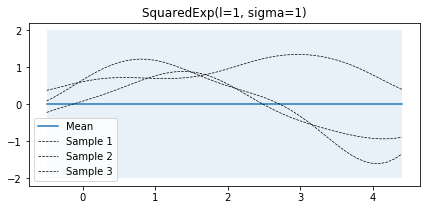

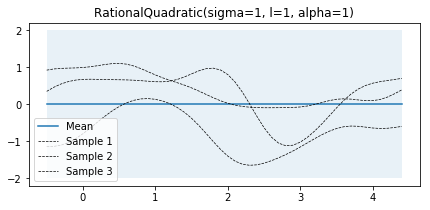

In [4]:
for k in [SquaredExp(), RationalQuadratic()]: #, Linear()]:
    print(k)
    GaussianProcess(kernel=k).plot_prior(X)

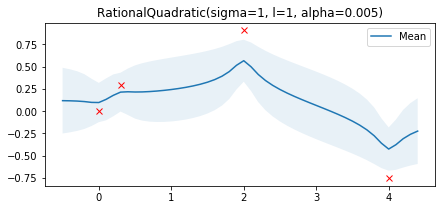

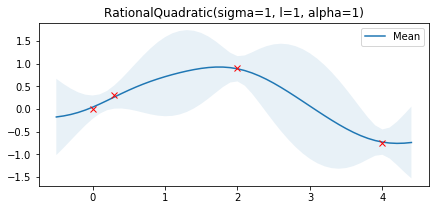

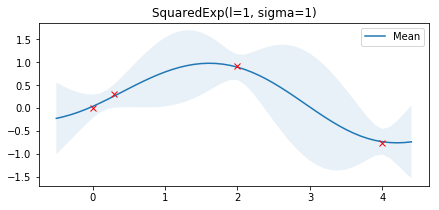

In [5]:
for kernel in [RationalQuadratic(alpha=0.005), RationalQuadratic(), SquaredExp()]: #, Linear()]:
    GaussianProcess(kernel=kernel).with_noise(.02)\
        .posterior(X, X_train, y_train).plot_posterior(num_samples=0)

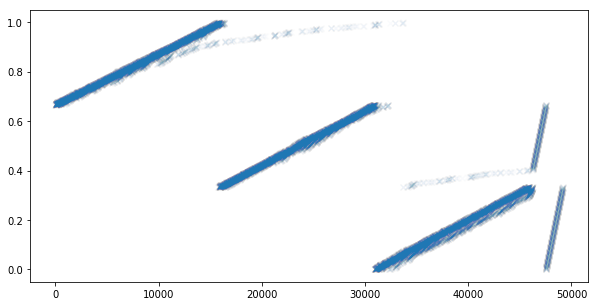

In [6]:
values = np.genfromtxt("matmul_faults.txt", converters={0:lambda s: int(s, 16)}, dtype=np.int64)
from sklearn.preprocessing import MinMaxScaler
values = MinMaxScaler().fit_transform(values.reshape(-1, 1).astype(np.float64))

plt.figure(figsize=(10,5))
plt.plot(values, "x", alpha=0.01)

In [7]:
offset = 0
num = 500
X = np.array(list(range(len(values))))[offset:offset + num]
y = values[offset:offset + num].reshape(-1)

C:\dev\Miniconda3\lib\site-packages\numpy\linalg\linalg.py:2010: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
C:\dev\Miniconda3\lib\site-packages\scipy\optimize\optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


Found optimal params [ 4.52309355 37.21759547]


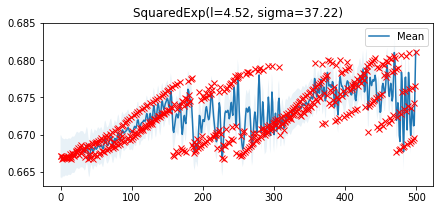

In [8]:
GaussianProcess().fit(X, y).optimize_kernel().posterior(X).plot_posterior(num_samples=0)

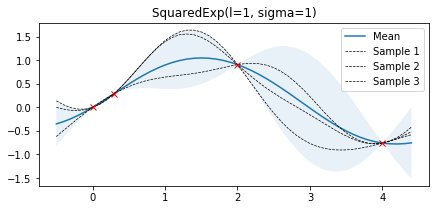

In [9]:
X_train = np.array([0, 0.3, 2, 4])
y_train = np.sin(X_train)

X = np.arange(min(X_train) - 0.5, max(X_train) + 0.5, step=0.1)

gp = GaussianProcess()
gp.kernel = gp.kernel.with_round_indexes(np.array([0]))
gp.posterior(X, X_train, y_train).plot_posterior()

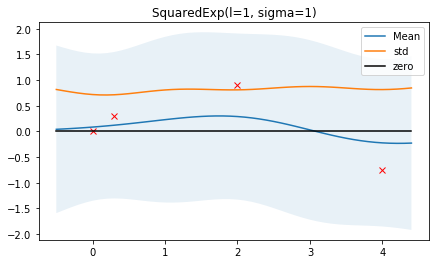

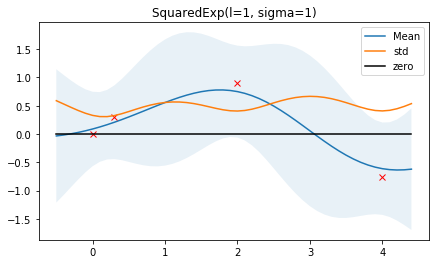

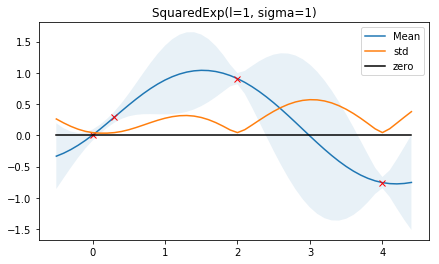

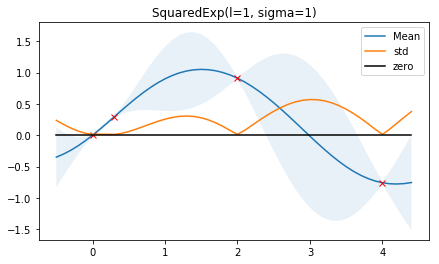

In [10]:
for noise in [2, 0.2, 0.002, 0.0002]:
    gp = GaussianProcess().with_noise(noise).posterior(X, X_train, y_train)
    plt.figure(figsize=(7,4))
    gp.plot_posterior(num_samples=0, figure=False)
    plt.plot(X, np.sqrt(np.diag(gp.cov)), label="std")
    plt.plot(X, np.zeros_like(X), label="zero", c="k")
    plt.legend()
    plt.show()

## Kernel params

Found optimal params [1.11879702 1.2438052 ]


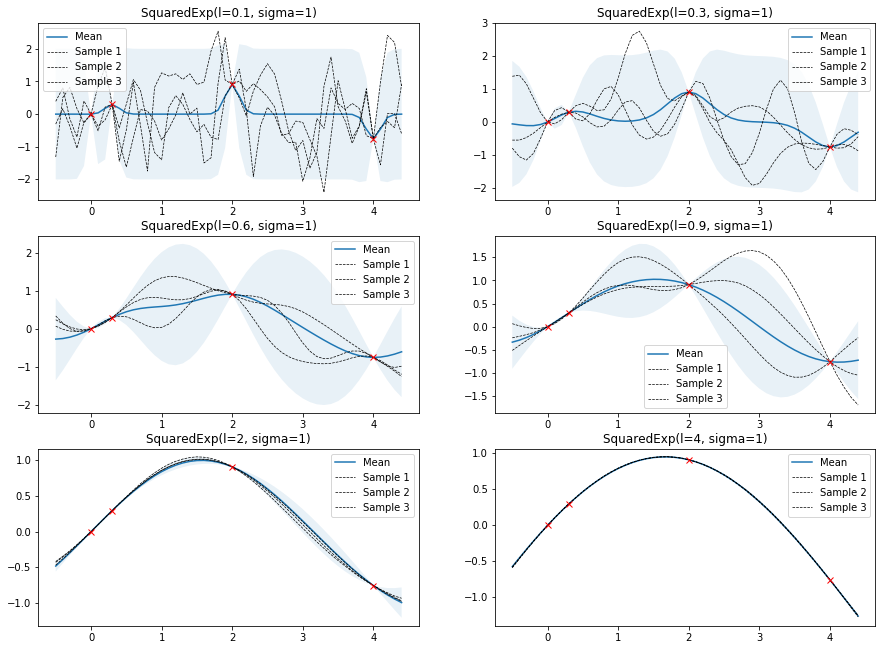

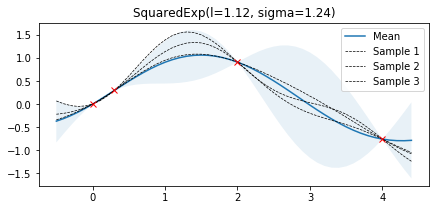

In [11]:
params = [0.1, 0.3, 0.6, 0.9, 2, 4]

gp = GaussianProcess()

plt.figure(figsize=(15,15))
for i, l in enumerate(params):
    num_rows = len(params) // 2 + 1

    plt.subplot(num_rows, 2, i+1)
    
    gp.with_kernel_params([l, 1]).fit(X_train, y_train).posterior(X).plot_posterior(figure=False)

gp.fit(X_train, y_train).optimize_kernel().posterior(X).plot_posterior()

## Optimizing kernel parameters

$$
\begin{align}
    \log p(y|X) &= \log N(y|0, K_y) \\
                &= -\frac{1}{2} y^T K_y^{-1} y - \frac{1}{2} \log |K_y| - \frac{N}{2} \log(2 \pi)
\end{align}
$$

SquaredExp(l=2, sigma=1)

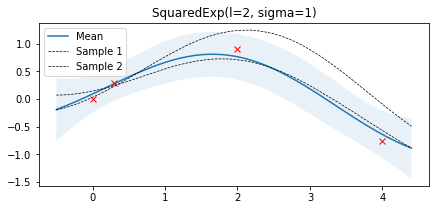

In [12]:
GaussianProcess(.05).fit(X_train, y_train)\
        .with_kernel_params([2, 1]).posterior(X).plot_posterior(num_samples=2).kernel

Found optimal params [1.11879702 1.2438052 ]


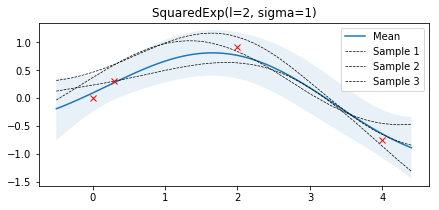

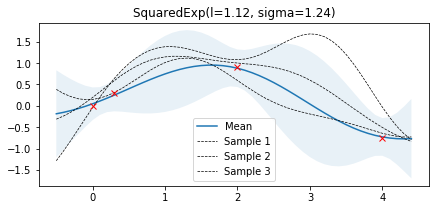

In [13]:
GaussianProcess(.05).fit(X_train, y_train)\
        .with_kernel_params([2, 1]).posterior(X).plot_posterior()\
        .optimize_kernel().posterior(X).plot_posterior()

## More general alternative to `np.meshgrid`

In [21]:
a = np.array([1,2]).reshape(-1, 1)
b = np.array([4,5]).reshape(1, -1)

a + b

array([[5, 6],
       [6, 7]])

In [22]:
a * b

array([[ 4,  5],
       [ 8, 10]])

## but how do I do this with tensordot on tensors?

In [23]:
a = np.array([[1,0],[2,0]]).reshape(-1, 1, 2)
b = np.array([[4,0],[5,0]]).reshape(1, -1, 2)

In [24]:
np.sqrt(((a - b) ** 2).sum(axis=2))

array([[3., 4.],
       [2., 3.]])

In [25]:
np.linalg.norm(a - b, axis=2)

array([[3., 4.],
       [2., 3.]])

In [26]:
np.tensordot(a, b, axes=2)

array([[4, 0],
       [8, 0]])

In [27]:
# This seems to work, but why are there the extra dimensions?
np.tensordot(a, b, axes=[2,2])

array([[[[ 4,  5]]],


       [[[ 8, 10]]]])

In [28]:
np.tensordot(a, b, axes=((1, 2), (0, 2)))

array([[ 4,  5],
       [ 8, 10]])

In [29]:
z = np.zeros((a.shape[0], b.shape[1]))

for i in range(a.shape[0]):
    for j in range(b.shape[1]): 
        z[i, j] = a[i, 0] @ b[0, j]

z

array([[ 4.,  5.],
       [ 8., 10.]])

In [30]:
a = np.array([[1,0],[2,0]]).reshape(-1, 1, 2)
b = np.array([[4,0],[5,0]]).reshape(1, -1, 2)

za = np.zeros_like(a)
zb = np.zeros_like(b)

aa = a + zb
bb = b + za

np.tensordot(aa, bb, axes=((1,2), (0,2)))
# array([[ 8,  0],
#        [16,  0]])

array([[ 8, 10],
       [16, 20]])

## Workaround with one loop

In [31]:
a = np.array([[1,0],[2,0]])
b = np.array([[4,0],[5,0]])

bb = b.T

rows = []

for i in range(a.shape[0]):
    rows.append(a[i] @ bb)

res = np.array(rows)

In [32]:
np.array(rows)

array([[ 4,  5],
       [ 8, 10]])

# Bayesian Optimization

http://krasserm.github.io/2018/03/21/bayesian-optimization/

In [33]:
from myopt.bayesian_optimization import Float, Integer
bounds = [Float(-1.0, 2.0)]
noise = 0.2

def f(X):
    return -np.sin(3*X) - X**2 + 0.7*X

X_init = np.array([[-0.9], [1.1]])
y_init = f(X_init)

# Dense grid of points within bounds
X_true = np.arange(bounds[0].low, bounds[0].high, 0.01).reshape(-1, 1)

# Noise-free objective function values at X 
y_true = f(X_true)

In [34]:
from myopt.bayesian_optimization import bo_minimize
bo_minimize(lambda x: f(x) + np.random.randn(1)*0.001, bounds)

Found optimal params [1.         0.88675773]
Found optimal params [2.76540482 1.2791619 ]
Found optimal params [0.9499312 1.1611072]
Found optimal params [1.50829633 1.85783326]
Found optimal params [0.52585347 1.40732425]
Found optimal params [0.53641744 1.62086637]
Found optimal params [0.57630161 2.22644653]
max_x [-0.32934369] max max 0.49441588920995455


array([-0.32934369])

In [35]:
np.array([[1], [2]]) + np.array([1, 1])

array([[2, 2],
       [3, 3]])

Found optimal params [1.         1.51951442]
Found optimal params [7.84147561 1.73486649]
Found optimal params [0.21332863 1.13917523]
Found optimal params [0.44664593 1.39798281]
Found optimal params [0.42086442 1.27015716]
Found optimal params [0.60728426 1.66433647]
Found optimal params [0.41071324 1.23430963]
max_x [-0.37660185] max max 0.4984456613925093


array([-0.37660185])

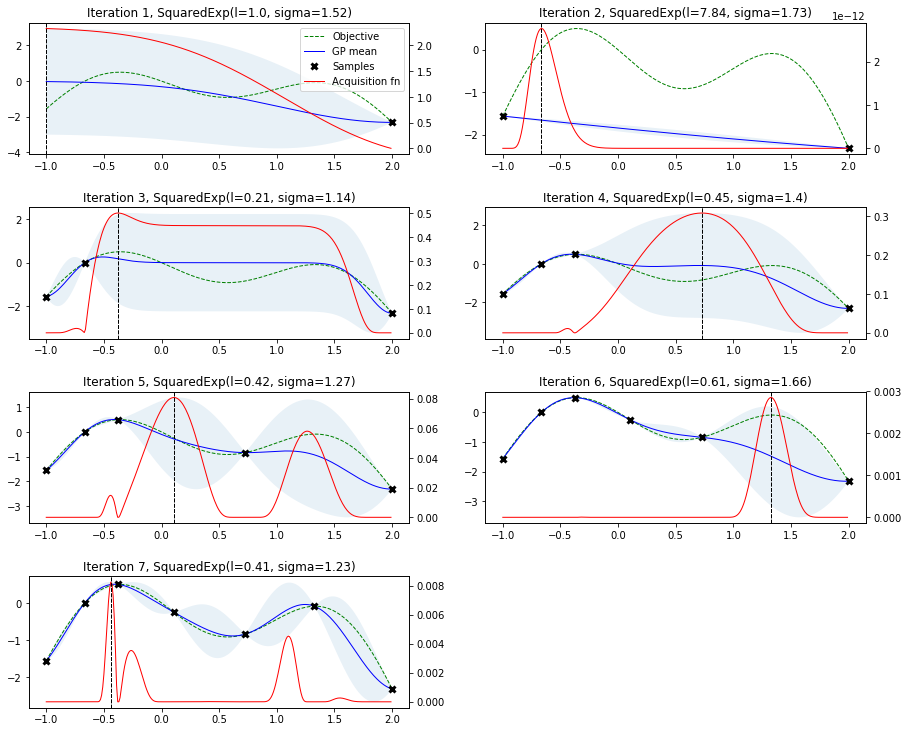

In [36]:
bo_plot_exploration(lambda x: f(x) + np.random.randn(1)*0.001, bounds, X_init, y_init, X_true=X_true, y_true=y_true, n_iter=8)

Found optimal params [1.         0.50288055]
Found optimal params [1.09378913 1.18795488]
Found optimal params [0.76272578 1.14383718]
Found optimal params [0.98352743 1.40468257]
Found optimal params [0.52971423 1.41059521]
Found optimal params [0.55673566 1.78487482]
Found optimal params [0.50192171 1.59534373]
Found optimal params [0.53974747 2.14988423]
Found optimal params [0.73234129 3.77734984]
max_x [-0.35373076] max max 0.500200751912456


array([-0.35373076])

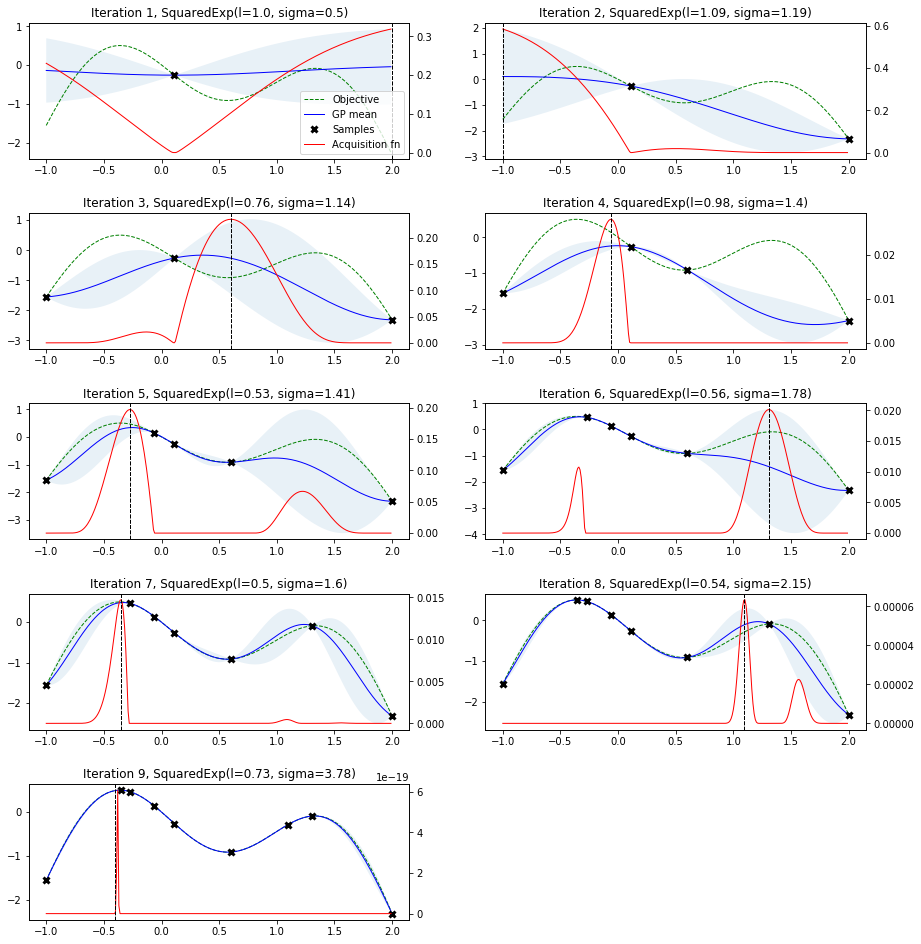

In [37]:
bo_plot_exploration(f, bounds, X_init, y_init, X_true=X_true, y_true=y_true, n_iter=10, optimize_kernel=True)

## GP benchmarks

In [110]:
noise = 0.2

# Noisy training data
X_train = 400*np.random.rand(100) - 200
y_train = np.sin(X_train) + noise * np.random.randn(*X_train.shape)

X = np.arange(-200, 200, 0.2)
%prun GaussianProcess().fit(X_train, y_train).optimize_kernel().posterior(X).plot_posterior(num_samples=2)

Found optimal params [0.84913349 1.20582501]


IndexError: tuple index out of range

In [111]:
noise = 0.2

# Noisy training data
X_train = 400*np.random.rand(100) - 200
y_train = np.sin(X_train) + noise * np.random.randn(*X_train.shape)


X = np.arange(-200, 200, 0.2)
%time GaussianProcess().fit(X_train, y_train).posterior(X).plot_posterior(num_samples=2)

X = np.arange(-200, 200, 0.1)
%time GaussianProcess().fit(X_train, y_train).posterior(X).plot_posterior(num_samples=2)

IndexError: tuple index out of range

IndexError: tuple index out of range

## 2D bayes opt

In [112]:
from myopt.bayesian_optimization import plot_2d_optim_result

In [145]:
def f(x):
    return np.sin(np.linalg.norm(x/2))

bounds = [Integer(-5, 8), Float(-2, 3), Float(0, 10), Integer(2, 10), Float(-2, 3), Float(0, 10), Integer(2, 10), Float(-2, 3), Float(0, 10), Integer(2, 10)]

from myopt.bayesian_optimization import bo_minimize
%prun res = bo_minimize(f, bounds, n_iter=10)

Found optimal params [1.         0.59081333]
Found optimal params [1.         0.71263382]
Found optimal params [1.        0.8587936]
Found optimal params [1.         0.91658124]
Found optimal params [4.84796722 1.04709829]
Found optimal params [6.06759128 1.18877093]
Found optimal params [6.73995197 1.26437644]
Found optimal params [4.71609622 1.07275712]
Found optimal params [4.97090235 1.14287917]
max_x [4.         1.46919604 4.55570415 3.         3.         3.85301201
 8.         2.436474   8.02741353 4.        ] max max 0.9203218627249
 

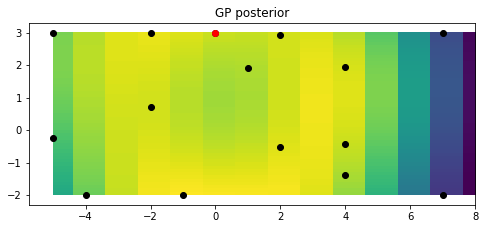

In [141]:
plot_2d_optim_result(res)

Found optimal params [ 1.20304214 15.15308694]


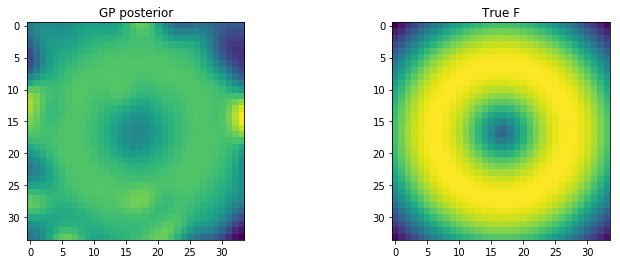

In [107]:
from myopt.plot import plot_gp_2D
from mpl_toolkits.mplot3d import axes3d, Axes3D

noise_2d = 0.01

rx, ry = np.arange(-5, 5, 0.3), np.arange(-5, 5, 0.3)
gx, gy = np.meshgrid(rx, rx)

X_2d = np.c_[gx.ravel(), gy.ravel()]

X_2d_train = np.random.uniform(-4, 4, (150, 2))
y_2d_train = np.sin(0.5 * np.linalg.norm(X_2d_train, axis=1))# + noise_2d * np.random.randn(len(X_2d_train))

mu_s, _ = GaussianProcess().fit(X_2d_train, y_2d_train).optimize_kernel().posterior(X_2d).mu_std()

plt.figure(figsize=(12, 4))
plt.subplot(121); plt.title("GP posterior");
plt.imshow(mu_s.reshape(gx.shape[0], gy.shape[0]))

plt.subplot(122); plt.title("True F");
plt.imshow(np.sin(0.5 * np.linalg.norm(X_2d, axis=1)).reshape(gx.shape[0], gy.shape[0]))

Found optimal params [1.93901103 7.04068075]


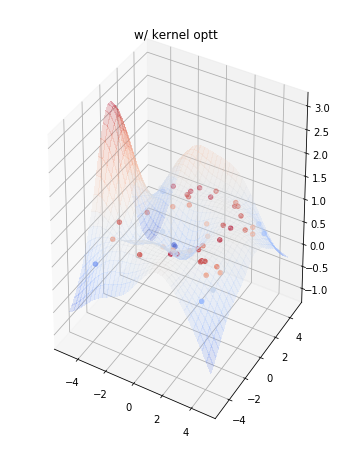

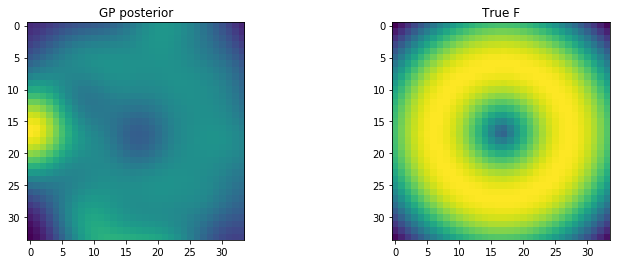

In [108]:
from myopt.plot import plot_gp_2D
from mpl_toolkits.mplot3d import axes3d, Axes3D

noise_2d = 0.01

rx, ry = np.arange(-5, 5, 0.3), np.arange(-5, 5, 0.3)
gx, gy = np.meshgrid(rx, rx)

X_2d = np.c_[gx.ravel(), gy.ravel()]

X_2d_train = np.random.uniform(-4, 4, (50, 2))
y_2d_train = np.sin(0.5 * np.linalg.norm(X_2d_train, axis=1))# + noise_2d * np.random.randn(len(X_2d_train))

# plt.figure(figsize=(14,7))

# mu_s, _ = GaussianProcess().fit(X_2d_train, y_2d_train).posterior(X_2d).mu_std()

#plot_gp_2D(gx, gy, mu_s, X_2d_train, y_2d_train, "LOL it works", 1)
#plt.show()

mu_s, _ = GaussianProcess().fit(X_2d_train, y_2d_train).optimize_kernel().posterior(X_2d).mu_std()

plt.figure(figsize=(13,8))
plot_gp_2D(gx, gy, mu_s, X_2d_train, y_2d_train, "w/ kernel optt", 1)

plt.figure(figsize=(12, 4))
plt.subplot(121); plt.title("GP posterior"); plt.imshow(mu_s.reshape(gx.shape[0], gy.shape[0]))
plt.subplot(122); plt.title("True F"); plt.imshow(np.sin(0.5 * np.linalg.norm(X_2d, axis=1)).reshape(gx.shape[0], gy.shape[0]))

#%matplotlib inline
# mu_s, _ = posterior_predictive(X_2D, X_2D_train, Y_2D_train, sigma_y=noise_2D)
# plot_gp_2D(gx, gy, mu_s, X_2D_train, Y_2D_train, 
#            f'Before parameter optimization: l={1.00} sigma_f={1.00}', 1)

# res = minimize(nll_fn(X_2D_train, Y_2D_train, noise_2D), [1, 1], 
#                bounds=((1e-5, None), (1e-5, None)),
#                method='L-BFGS-B')

# mu_s, _ = posterior_predictive(X_2D, X_2D_train, Y_2D_train, *res.x, sigma_y=noise_2D)
# plot_gp_2D(gx, gy, mu_s, X_2D_train, Y_2D_train,
#            f'After parameter optimization: l={res.x[0]:.2f} sigma_f={res.x[1]:.2f}', 2)